In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libs

In [ ]:
# import modules
import pandas as pd
import numpy as np
from pylab import *
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 153MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=b71be7a13936ab83d3bbb35423c8361652c993e16c01d50e8777334eb2

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['CVS','ELV','JNJ','KO','COST','HSY','COP','SLB','MPC']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}

In [ ]:
dow_prices

{'CVS':                   open        high         low       close   adjclose  \
 2017-01-03   79.580002   80.449997   78.970001   80.349998  67.042549   
 2017-01-04   80.339996   80.419998   79.440002   79.750000  66.541924   
 2017-01-05   79.849998   81.519997   78.800003   81.419998  67.935341   
 2017-01-06   81.410004   82.459999   80.940002   82.199997  68.586182   
 2017-01-09   82.199997   82.379997   81.160004   81.699997  68.168976   
 ...                ...         ...         ...         ...        ...   
 2021-12-23  101.070000  101.870003  101.070000  101.309998  97.592316   
 2021-12-27  101.760002  102.419998  101.559998  102.400002  98.642326   
 2021-12-28  102.500000  103.250000  102.360001  102.769997  98.998749   
 2021-12-29  103.099998  103.839996  103.029999  103.699997  99.894623   
 2021-12-30  103.989998  104.559998  103.449997  103.680000  99.875359   
 
              volume ticker  
 2017-01-03  5922800    CVS  
 2017-01-04  7101800    CVS  
 2017-01-05  

In [ ]:
# let's extract just the data we need (adjclose)
# get the adjclose price for the NFLX (one sample)
prep_data = pd.DataFrame(dow_prices['CVS']['adjclose']).rename(columns = {"adjclose":"CVS"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data.head()

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
2017-01-03,67.042549,132.691544,97.481964,34.231304,141.104660,90.249245,41.450989,70.263840,42.216400
2017-01-04,66.541924,132.515549,97.322075,34.108475,141.131165,90.422920,41.835934,70.785843,40.868469
2017-01-05,67.935341,133.923584,98.340317,34.190361,143.913834,89.841064,41.713078,70.678108,40.716934
2017-01-06,68.586182,133.719788,97.869064,34.182171,143.843170,90.761627,41.557465,71.655846,40.174576
2017-01-09,68.168976,132.274643,97.852234,33.838219,142.200027,90.223198,40.672920,71.067535,39.448769


In [ ]:
prep_data.isnull().sum()

CVS     0
ELV     0
JNJ     0
KO      0
COST    0
HSY     0
COP     0
SLB     0
MPC     0
dtype: int64

## There are no null values in the time series data

In [ ]:
prep_data.shape

(1258, 9)

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# drop the na records
return_data.dropna(inplace=True)
return_data.head()

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
2017-01-04,-0.007467,-0.001326,-0.001640,-0.003588,0.000188,0.001924,0.009287,0.007429,-0.031929
2017-01-05,0.020940,0.010625,0.010463,0.002401,0.019717,-0.006435,-0.002937,-0.001522,-0.003708
2017-01-06,0.009580,-0.001522,-0.004792,-0.000240,-0.000491,0.010247,-0.003731,0.013834,-0.013320
2017-01-09,-0.006083,-0.010807,-0.000172,-0.010062,-0.011423,-0.005932,-0.021285,-0.008210,-0.018066
2017-01-10,0.011873,0.024862,-0.001032,-0.006776,0.004287,0.009048,0.000000,-0.013641,-0.009907


In [ ]:
return_data.shape

(1257, 9)

## 1.2 Time Series Visualizations






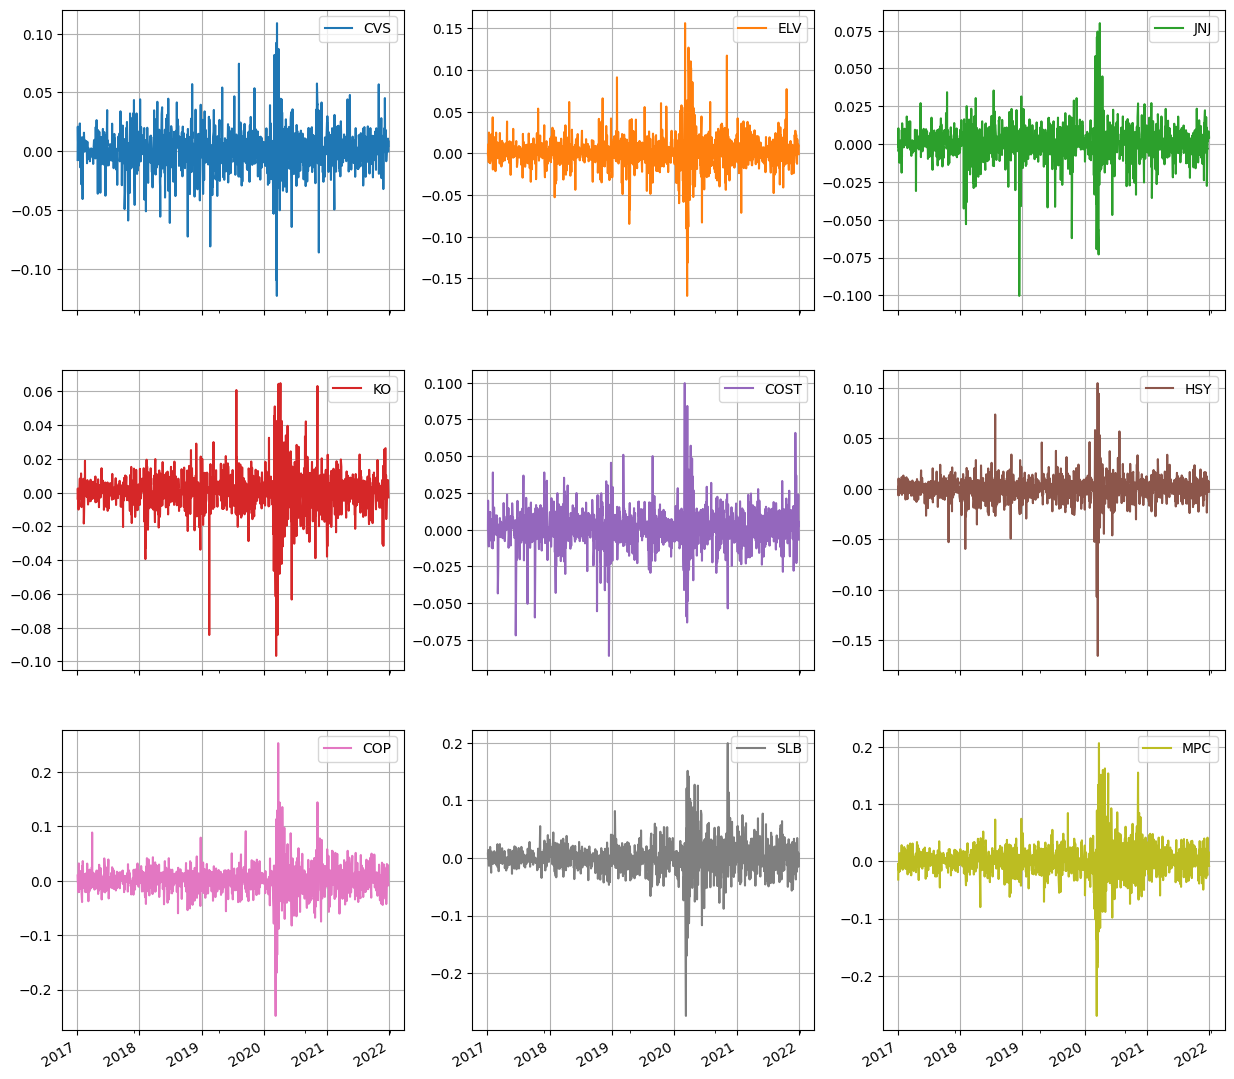

In [ ]:
return_data.plot(subplots=True,
        grid=True,
        layout=(3,3),
         figsize=(15,15)),

plt.show()

### 1.2.1 Visualization of Healthcare Sector

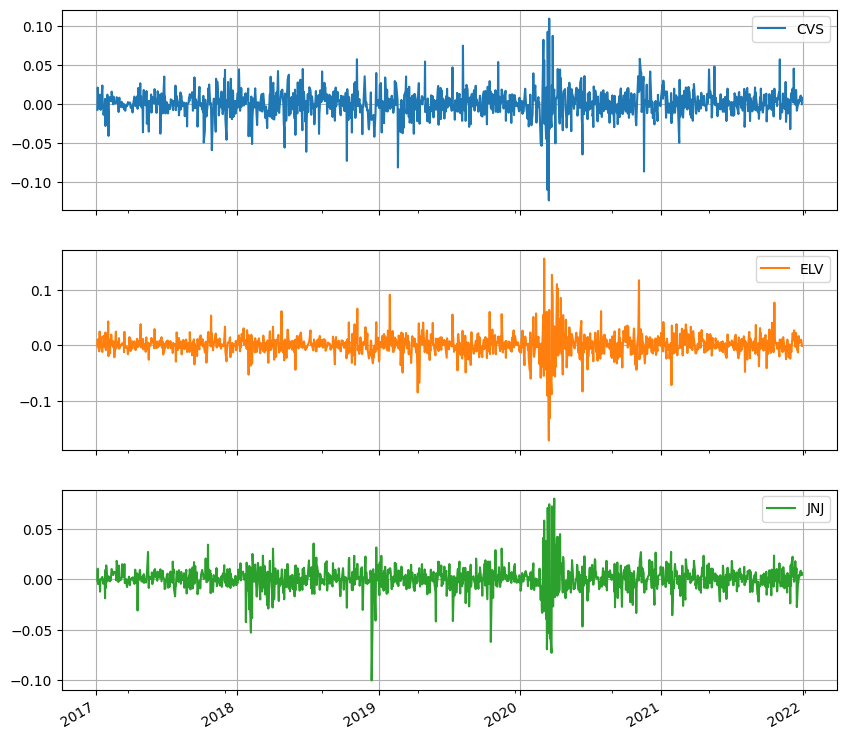

In [ ]:
return_data[['CVS','ELV','JNJ']].plot(subplots=True,
        grid=True,
        layout=(3,1),
         figsize=(10,10))
plt.show()

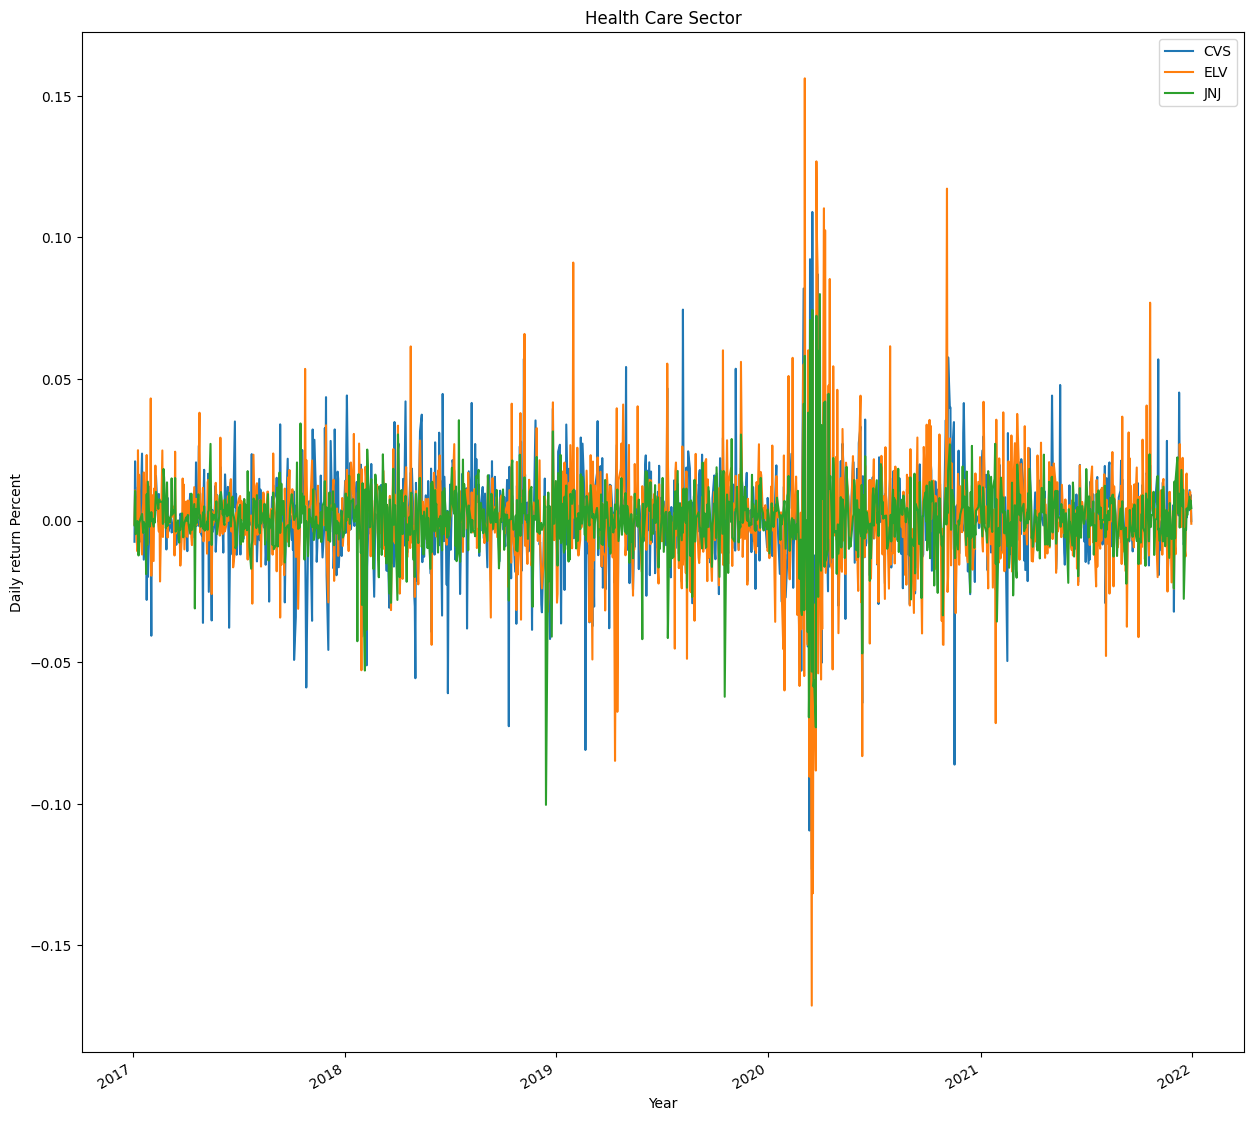

In [ ]:
# Create a line plot of the daily return percentage for three stocks from real estate sector over time
healthcare_return_data = return_data.loc[:,['CVS','ELV','JNJ']]
healthcare_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Health Care Sector')

plt.show()

### 1.2.2 Visualization of Consumer Staples Sector

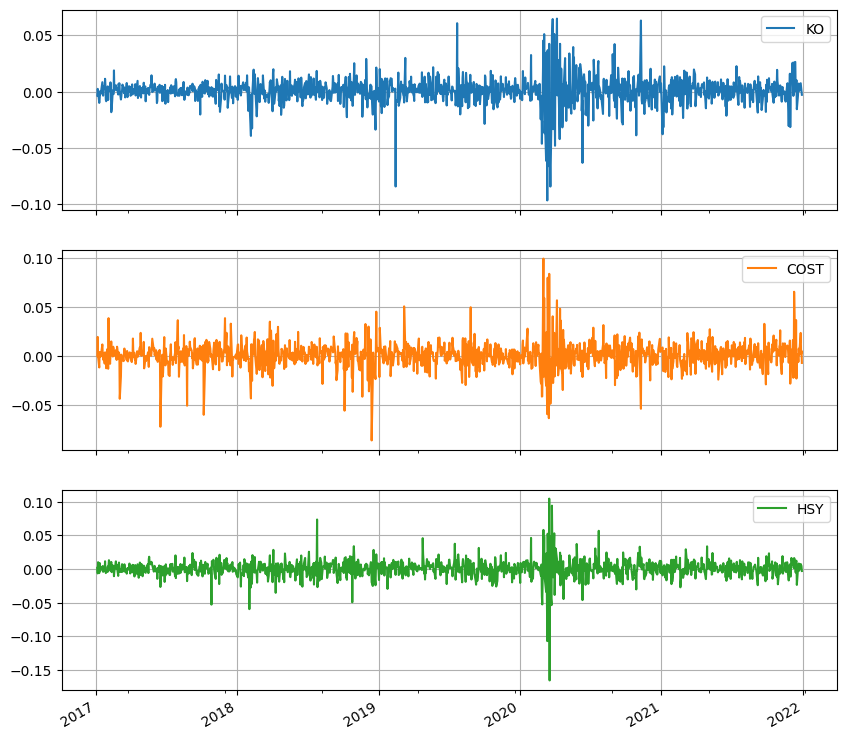

In [ ]:
return_data[['KO','COST','HSY']].plot(subplots=True,
        grid=True,
        layout=(3,1),
         figsize=(10,10))
plt.show()

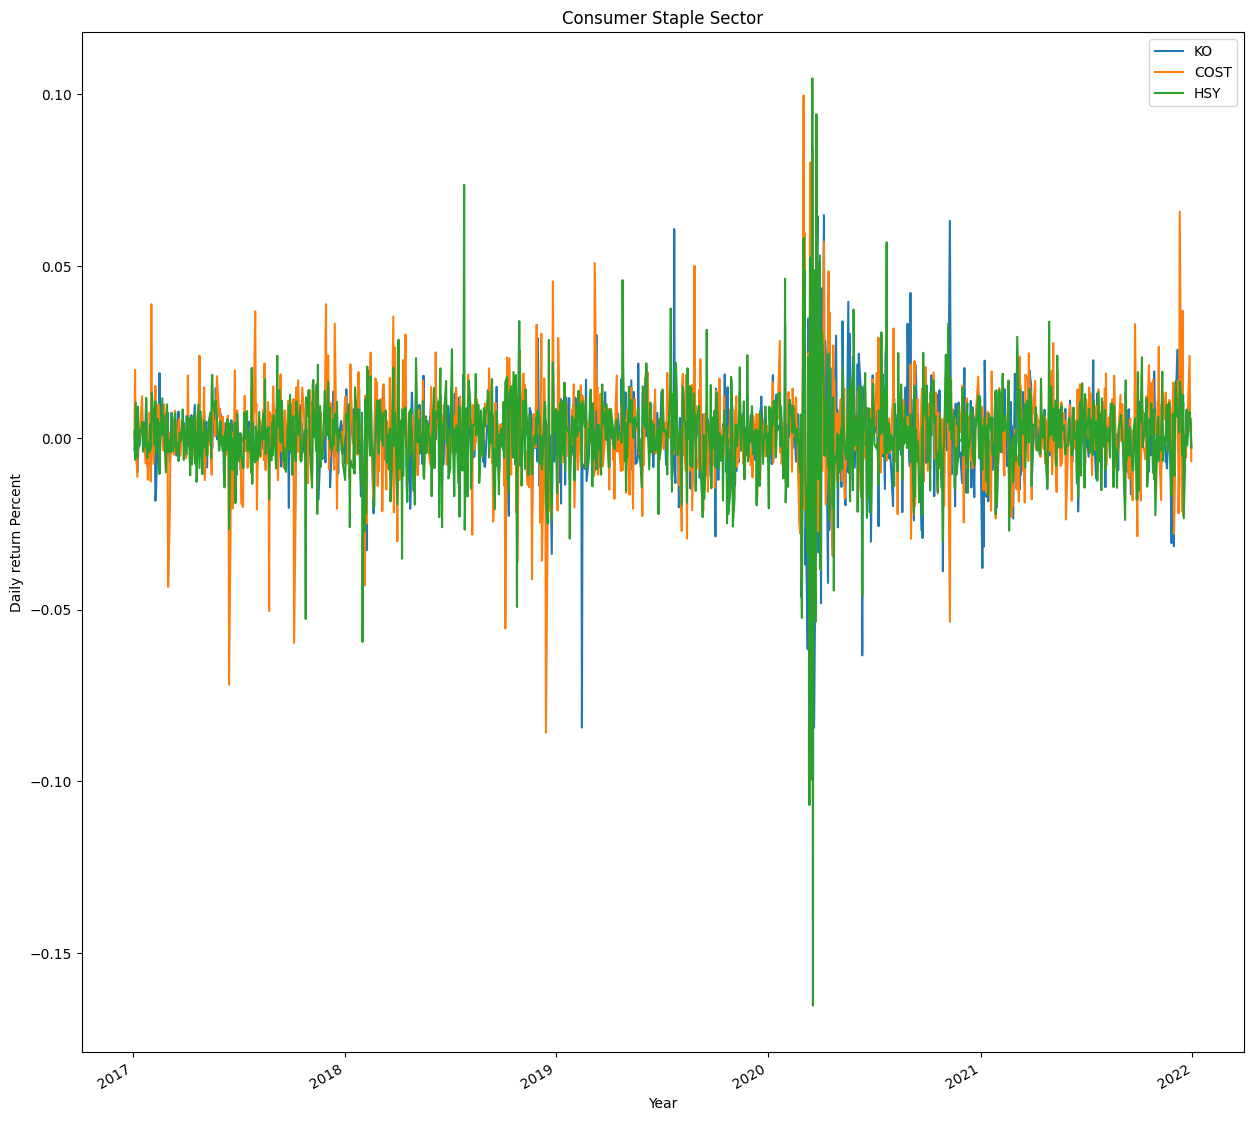

In [ ]:
# Create a line plot of the daily return percentage for three stocks from real estate sector over time
healthcare_return_data = return_data.loc[:,['KO','COST','HSY']]
healthcare_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Consumer Staple Sector')

plt.show()

### 1.2.3 Visualization of Energy Sector

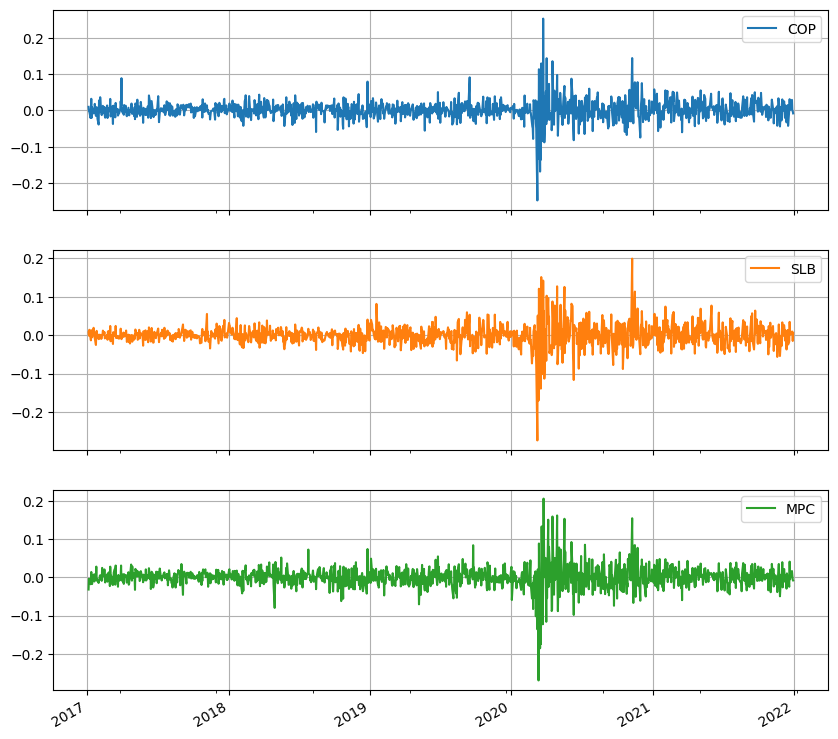

In [ ]:
return_data[['COP','SLB','MPC']].plot(subplots=True,
        grid=True,
        layout=(3,1),
         figsize=(10,10))
plt.show()

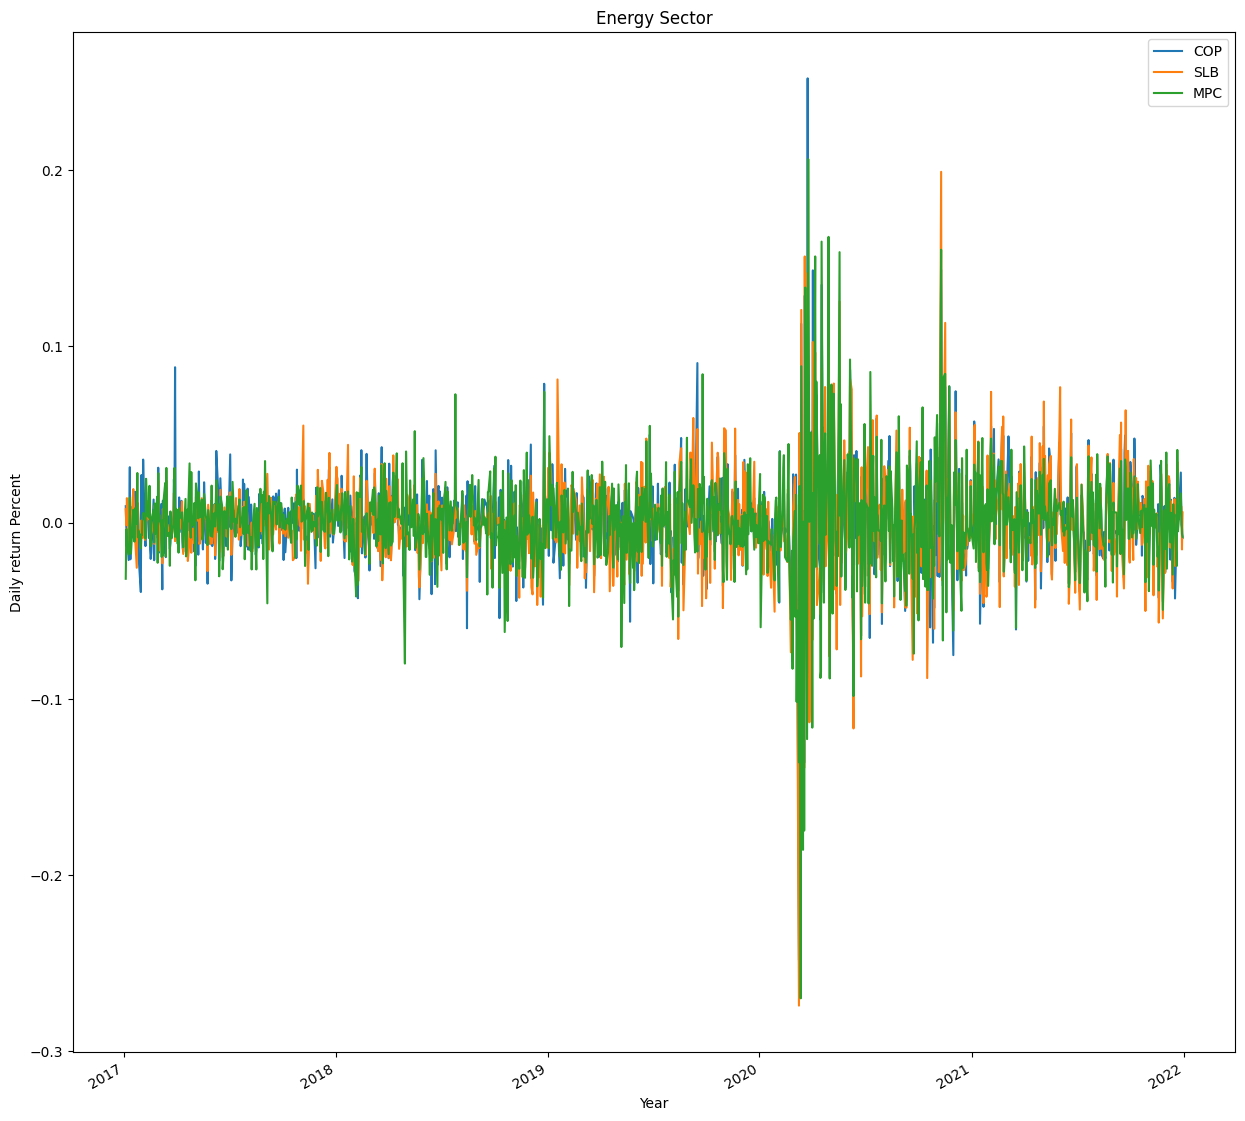

In [ ]:
# Create a line plot of the daily return percentage for three stocks from real estate sector over time
healthcare_return_data = return_data.loc[:,['COP','SLB','MPC']]
healthcare_return_data.plot(figsize=(15,15))

plt.xlabel('Year')
plt.ylabel('Daily return Percent')
plt.title('Energy Sector')

plt.show()

## 1.3 - Discussion of the Plots

1) From the percentage change plots, it can be observed that all the nine stocks had a drastic fall in 2020 due to covid pandemic and all of them made a tremendous recovery as well immediately after that. When the first covid pandemic stuck, the three stocks in the energy sector have fallen by more than 20% in a day which was the highest when compared to the fall in stocks from the other two sectors. When the stocks subsequently made a recovery post pandemic fall, the three stocks in the energy sector have gained around 20% in a day which was again the highest when compared to the gain in stocks from the other two sectors. There are certain other periods as well where the movement in the energy stocks were higher compared to the movement in the stocks of the other sectors indicating that the magnitude of the percentage change in energy sector is higher comparatively, implying higher risk in the energy sector.

2) Among the three healthcare sector stocks, 'ELV' had higher daily percentage change fluctuations on both upside and downside indicating that the stock is more volaitle while 'JNJ' had lower daily percentage change fluctuations on both upside and downside indicating that the stock is less volatile.

3) Among the three consumer staple sector stocks, 'HSY' had higher daily percentage change fluctuations on both upside and downside indicating that the stock is more volatile.

4) All the three energy sector stocks had similar trend and the periods of higher and lower volatility were common implying that they was convegence for all the three stocks.

5) We observed that there were periods of both convergence and divergence for healthcare sector stocks as well as consumer staple sector stocks.

# 2 - Optimization Model



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 155MB/s]


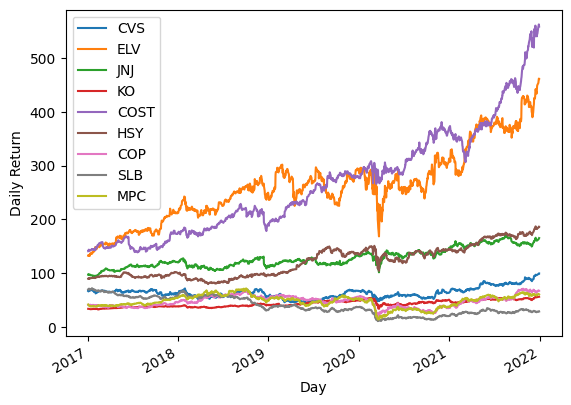

In [ ]:
# Visualization of daily return of all the stocks
prep_data.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()

In [ ]:
Avg_Return = pd.DataFrame(np.mean(prep_data) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(prep_data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
CVS    64.169076
ELV   262.811790
JNJ   127.955093
KO     43.633783
COST  265.120469
HSY   121.658691
COP    47.887279
SLB    39.468384
MPC    48.486835
      Std_Dev_Return
CVS        10.023023
ELV        68.582200
JNJ        17.639035
KO          5.914877
COST       99.226168
HSY        28.888047
COP        10.307894
SLB        16.192622
MPC        11.285997


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


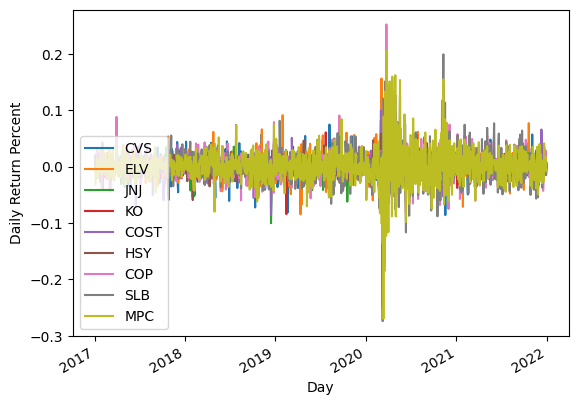

In [ ]:
# Visualization of daily return of all the stocks
return_data.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return Percent')
plt.show()

Now to see how the different stocks vary with each other, covariance of all the stocks to be calculated

In [ ]:
# here's the covariance matrix
Covariance_matrix = return_data.cov()
Covariance_matrix

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
CVS,0.000316,0.000183,0.000105,0.000093,0.000101,0.000088,0.000160,0.000178,0.000188
ELV,0.000183,0.000423,0.000121,0.000116,0.000100,0.000122,0.000218,0.000218,0.000253
JNJ,0.000105,0.000121,0.000159,0.000087,0.000079,0.000081,0.000104,0.000103,0.000110
KO,0.000093,0.000116,0.000087,0.000161,0.000070,0.000100,0.000126,0.000136,0.000165
COST,0.000101,0.000100,0.000079,0.000070,0.000184,0.000081,0.000067,0.000066,0.000084
HSY,0.000088,0.000122,0.000081,0.000100,0.000081,0.000196,0.000113,0.000103,0.000123
COP,0.000160,0.000218,0.000104,0.000126,0.000067,0.000113,0.000695,0.000592,0.000512
SLB,0.000178,0.000218,0.000103,0.000136,0.000066,0.000103,0.000592,0.000780,0.000554
MPC,0.000188,0.000253,0.000110,0.000165,0.000084,0.000123,0.000512,0.000554,0.000831


In [ ]:
min(min(Covariance_matrix['CVS']),min(Covariance_matrix['ELV']),min(Covariance_matrix['JNJ']),
min(Covariance_matrix['KO']),min(Covariance_matrix['COST']),min(Covariance_matrix['HSY']),
min(Covariance_matrix['COP']),min(Covariance_matrix['SLB']),min(Covariance_matrix['MPC']))

6.591013104122398e-05

In [ ]:
Covariance_matrix[Covariance_matrix ==6.591033659932424e-05]

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
CVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JNJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# here's the correlation martix
Corr_matrix = return_data.corr()
Corr_matrix

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
CVS,1.000000,0.501064,0.466567,0.410936,0.417390,0.355045,0.340520,0.357895,0.367728
ELV,0.501064,1.000000,0.464732,0.445995,0.359750,0.422484,0.401938,0.379304,0.427041
JNJ,0.466567,0.464732,1.000000,0.540491,0.462181,0.457630,0.311037,0.291006,0.302912
KO,0.410936,0.445995,0.540491,1.000000,0.406343,0.561862,0.376782,0.384435,0.452358
COST,0.417390,0.359750,0.462181,0.406343,1.000000,0.425892,0.187726,0.173810,0.213618
HSY,0.355045,0.422484,0.457630,0.561862,0.425892,1.000000,0.305921,0.262481,0.305402
COP,0.340520,0.401938,0.311037,0.376782,0.187726,0.305921,1.000000,0.803586,0.673825
SLB,0.357895,0.379304,0.291006,0.384435,0.173810,0.262481,0.803586,1.000000,0.688050
MPC,0.367728,0.427041,0.302912,0.452358,0.213618,0.305402,0.673825,0.688050,1.000000


In [ ]:
# Create covariance table on stock return dataframe
df_cov = return_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # returns a new line

# create the average of each stock
# These coefficients represent the objective function.
df_return = return_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           CVS       ELV       JNJ        KO      COST       HSY       COP  \
CVS   0.000316  0.000183  0.000105  0.000093  0.000101  0.000088  0.000160   
ELV   0.000183  0.000423  0.000121  0.000116  0.000100  0.000122  0.000218   
JNJ   0.000105  0.000121  0.000159  0.000087  0.000079  0.000081  0.000104   
KO    0.000093  0.000116  0.000087  0.000161  0.000070  0.000100  0.000126   
COST  0.000101  0.000100  0.000079  0.000070  0.000184  0.000081  0.000067   
HSY   0.000088  0.000122  0.000081  0.000100  0.000081  0.000196  0.000113   
COP   0.000160  0.000218  0.000104  0.000126  0.000067  0.000113  0.000695   
SLB   0.000178  0.000218  0.000103  0.000136  0.000066  0.000103  0.000592   
MPC   0.000188  0.000253  0.000110  0.000165  0.000084  0.000123  0.000512   

           SLB       MPC  
CVS   0.000178  0.000188  
ELV   0.000218  0.000253  
JNJ   0.000103  0.000110  
KO    0.000136  0.000165  
COST  0.000066  0.000084  
HSY   0.000103  0.000123  
COP   0.000

In [ ]:
min(df_cov)

'COP'

## 2.1 Model execution

In [ ]:
model = ConcreteModel()
# Defining variables
# Each one is a stock ('CVS','ELV','JNJ','KO','COST','HSY','COP','SLB','MPC')
# Health Care Sector('CVS','ELV','JNJ')
model.CVS = Var(within=NonNegativeReals, bounds=(0,1))
model.ELV = Var(within=NonNegativeReals, bounds=(0,1))
model.JNJ = Var(within=NonNegativeReals, bounds=(0,1))
# Consumer Staples sector('KO','COST','HSY')
model.KO = Var(within=NonNegativeReals, bounds=(0,1))
model.COST = Var(within=NonNegativeReals, bounds=(0,1))
model.HSY = Var(within=NonNegativeReals, bounds=(0,1))
# Energy sector('COP','SLB','MPC')
model.COP = Var(within=NonNegativeReals, bounds=(0,1))
model.SLB = Var(within=NonNegativeReals, bounds=(0,1))
model.MPC = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
model.pprint()

9 Var Declarations
    COP : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    COST : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    CVS : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    ELV : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    HSY : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    JNJ : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
  

In [ ]:
# declare objective
objective_expr = (
    model.CVS*df_return[0] + model.ELV*df_return[1] + model.JNJ*df_return[2] +
    model.KO*df_return[3] + model.COST*df_return[4] + model.HSY*df_return[5] +
    model.COP*df_return[6] + model.SLB*df_return[7] + model.MPC*df_return[8]
)


model.objective = Objective(
    expr = objective_expr,
    sense = maximize
) # yes, we want to MAX our returns!

# declare constraints
# Sum of all proportions = 1
model.sum_proportions = Constraint(expr = model.CVS+model.ELV+model.JNJ+model.KO+model.COST+model.HSY+model.COP+model.SLB+model.MPC == 1)

# Set maximum risk
model.total_risk = Constraint(expr = model.CVS+model.ELV+model.JNJ+model.KO+model.COST+model.HSY+model.COP+model.SLB+model.MPC >= 0.0)

In [ ]:
# Creating calculations table for calculate the risk
# Calculate risk
def calc_risk(model):
  variables = model.CVS, model.ELV, model.JNJ, model.KO, model.COST, model.HSY, model.COP, model.SLB, model.MPC
  tickers_list = ['CVS','ELV','JNJ','KO','COST','HSY','COP','SLB','MPC']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers_list[i],tickers_list[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(model)

# Max risk should be less than 0.01
max_risk = 0.00055
# Sequence of risk levels
risk_limits = np.arange(0.000066, max_risk, 0.0000066) # take tiny steps
risk_limits

array([6.600e-05, 7.260e-05, 7.920e-05, 8.580e-05, 9.240e-05, 9.900e-05,
       1.056e-04, 1.122e-04, 1.188e-04, 1.254e-04, 1.320e-04, 1.386e-04,
       1.452e-04, 1.518e-04, 1.584e-04, 1.650e-04, 1.716e-04, 1.782e-04,
       1.848e-04, 1.914e-04, 1.980e-04, 2.046e-04, 2.112e-04, 2.178e-04,
       2.244e-04, 2.310e-04, 2.376e-04, 2.442e-04, 2.508e-04, 2.574e-04,
       2.640e-04, 2.706e-04, 2.772e-04, 2.838e-04, 2.904e-04, 2.970e-04,
       3.036e-04, 3.102e-04, 3.168e-04, 3.234e-04, 3.300e-04, 3.366e-04,
       3.432e-04, 3.498e-04, 3.564e-04, 3.630e-04, 3.696e-04, 3.762e-04,
       3.828e-04, 3.894e-04, 3.960e-04, 4.026e-04, 4.092e-04, 4.158e-04,
       4.224e-04, 4.290e-04, 4.356e-04, 4.422e-04, 4.488e-04, 4.554e-04,
       4.620e-04, 4.686e-04, 4.752e-04, 4.818e-04, 4.884e-04, 4.950e-04,
       5.016e-04, 5.082e-04, 5.148e-04, 5.214e-04, 5.280e-04, 5.346e-04,
       5.412e-04, 5.478e-04])

In [ ]:
#print risk limit size
print(risk_limits.size)

74


In [ ]:
model.pprint()

9 Var Declarations
    COP : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    COST : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    CVS : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    ELV : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    HSY : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
    JNJ : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :     1 : False :  True : NonNegativeReals
  

# Running solver for allocation

In [ ]:
# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # WE REMOVE AND RECALCULATE THE RISK IN EACH ITERATION
  model.del_component(model.total_risk)
  # The LHS remains unchanged; we only modify the RHS (risk threshold)
  model.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(model).write()
  # store our allocation proportions
  param_analysis[r] = [model.CVS(), model.ELV(), model.JNJ(), model.KO(), model.COST(), model.HSY(), model.COP(), model.SLB(), model.MPC()]
  # store our returns
  # returns[r] = m.objective()
  returns[r] =  model.CVS()*df_return[0] + model.ELV()*df_return[1] + model.JNJ()*df_return[2] + model.KO()*df_return[3] + model.COST()*df_return[4] + model.HSY()*df_return[5] + model.COP()*df_return[6] + model.SLB()*df_return[7] + model.MPC()*df_return[8]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07105255126953125
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.038928985595703125
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03157448768615723
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.023145675659179688
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04366493225097656
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1577281951904297
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of s

## 2.2 Plot with allocation of the stocks

In [ ]:
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')

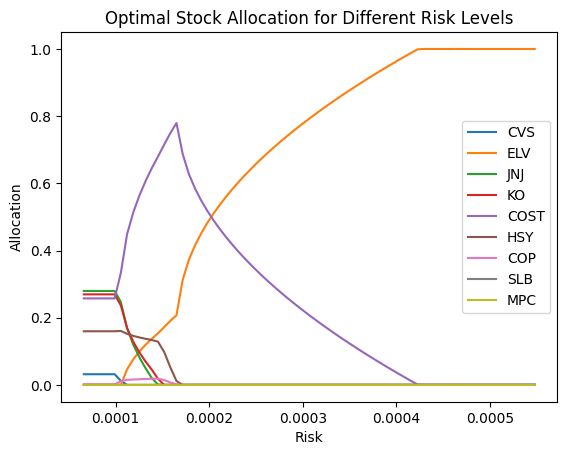

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis.columns = tickers_list
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
#label x and y axis
plt.xlabel('Risk')
plt.ylabel('Allocation')
plt.rcParams["figure.figsize"] = (8,6)
#plot graph
plt.show()

In [ ]:
print(param_analysis)

               CVS           ELV       JNJ        KO      COST       HSY  \
0.000066  0.031807  9.469882e-08  0.279532  0.269494  0.257467  0.159698   
0.000073  0.031807  2.798284e-08  0.279532  0.269496  0.257466  0.159697   
0.000079  0.031807  2.798284e-08  0.279532  0.269496  0.257466  0.159697   
0.000086  0.031807  9.469865e-08  0.279532  0.269495  0.257467  0.159697   
0.000092  0.031807  2.799221e-08  0.279532  0.269496  0.257466  0.159697   
...            ...           ...       ...       ...       ...       ...   
0.000521  0.000003  9.997014e-01  0.000004  0.000003  0.000271  0.000005   
0.000528  0.000003  9.996973e-01  0.000004  0.000003  0.000275  0.000005   
0.000535  0.000003  9.996937e-01  0.000004  0.000003  0.000279  0.000005   
0.000541  0.000003  9.996906e-01  0.000004  0.000003  0.000282  0.000005   
0.000548  0.000003  9.996878e-01  0.000004  0.000003  0.000285  0.000005   

               COP           SLB           MPC  
0.000066  0.001995  7.269235e-06  5.63

## 2.3 Plot with efficient frontier

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[6.6e-05, 7.26e-05, 7.92e-05, 8.58e-05, 9.24e-05, 9.9e-05, 0.00010559999999999999, 0.00011219999999999999, 0.00011879999999999999, 0.00012539999999999999, 0.00013199999999999998, 0.00013859999999999998, 0.00014519999999999998, 0.00015179999999999998, 0.00015839999999999997, 0.00016499999999999997, 0.00017159999999999997, 0.00017819999999999997, 0.00018479999999999997, 0.00019139999999999996, 0.00019799999999999996, 0.00020459999999999996, 0.00021119999999999996, 0.00021779999999999995, 0.00022439999999999995, 0.00023099999999999995, 0.00023759999999999995, 0.00024419999999999997, 0.0002507999999999999, 0.00025739999999999997, 0.0002639999999999999, 0.00027059999999999996, 0.0002771999999999999, 0.00028379999999999996, 0.0002903999999999999, 0.00029699999999999996, 0.0003035999999999999, 0.00031019999999999995, 0.0003167999999999999, 0.00032339999999999995, 0.0003299999999999999, 0.00033659999999999994, 0.0003431999999999999, 0.00034979999999999994, 0.0003563999999999999, 0.000362999999

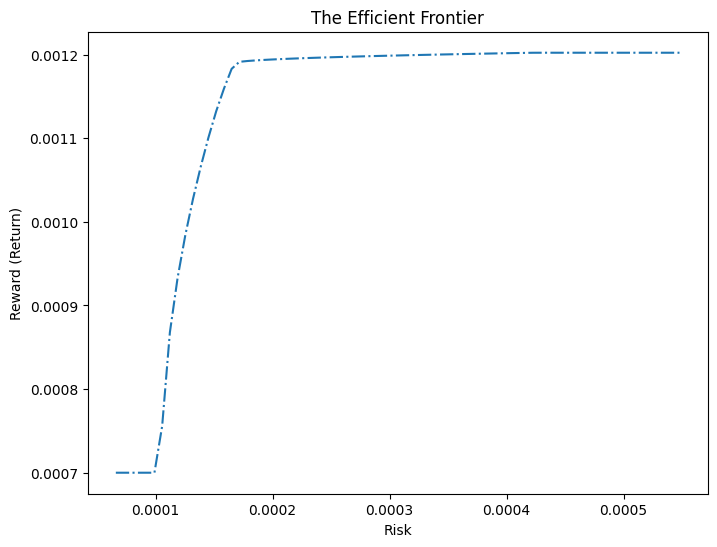

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

## 2.4 Portfolio selection

In [ ]:
param_analysis

,CVS,ELV,JNJ,KO,COST,HSY,COP,SLB,MPC
0.000066,0.031807,9.469882e-08,0.279532,0.269494,0.257467,0.159698,0.001995,7.269235e-06,5.638830e-08
0.000073,0.031807,2.798284e-08,0.279532,0.269496,0.257466,0.159697,0.002000,7.286101e-07,1.408398e-08
0.000079,0.031807,2.798284e-08,0.279532,0.269496,0.257466,0.159697,0.002000,5.460370e-07,1.408397e-08
0.000086,0.031807,9.469865e-08,0.279532,0.269495,0.257467,0.159697,0.002000,1.705863e-06,5.638597e-08
0.000092,0.031807,2.799221e-08,0.279532,0.269496,0.257466,0.159697,0.002001,5.655208e-07,1.410108e-08
...,...,...,...,...,...,...,...,...,...
0.000521,0.000003,9.997014e-01,0.000004,0.000003,0.000271,0.000005,0.000005,1.661083e-06,5.166662e-06
0.000528,0.000003,9.996973e-01,0.000004,0.000003,0.000275,0.000005,0.000005,1.661112e-06,5.166627e-06
0.000535,0.000003,9.996937e-01,0.000004,0.000003,0.000279,0.000005,0.000005,1.661142e-06,5.166636e-06
0.000541,0.000003,9.996906e-01,0.000004,0.000003,0.000282,0.000005,0.000005,1.661171e-06,5.166673e-06


In [ ]:
#Create a new DataFrame containing the top 3 coefficients
allocationDf = param_analysis.filter(items=[0.00025739999999999997], axis=0).reset_index().drop(columns=['index']).sort_values(by=0, axis=1, ascending=False).iloc[:,0:3]
allocationDf

,ELV,COST,COP
0,0.677486,0.322486,0.000006


# 3 - Analyis

## 3.1 - Buy-and-Hold strategy for the MPT portfolio

            Day        Open        High         Low       Close       8-day  \
2022-01-03   22  461.799988  465.029999  456.130005  464.859985  459.774998   
2022-01-04   23  465.769989  467.000000  457.570007  458.170013  462.071247   
2022-01-05   24  460.940002  465.130005  458.049988  458.220001  462.603748   
2022-01-06   25  445.829987  452.929993  432.970001  439.450012  462.917500   
2022-01-07   26  435.829987  438.420013  426.279999  434.989990  460.408752   
2022-01-10   27  434.209991  439.559998  430.790009  437.829987  456.756252   
2022-01-11   28  439.779999  454.970001  437.989990  453.730011  453.026249   
2022-01-12   29  452.779999  454.989990  448.489990  451.829987  451.348751   
2022-01-13   30  449.929993  451.880005  444.549988  446.829987  449.884998   
2022-01-14   31  448.339996  452.390015  446.339996  452.140015  447.631248   

                21-day  
2022-01-03  437.829046  
2022-01-04  440.929998  
2022-01-05  443.938094  
2022-01-06  446.538095  
2022-

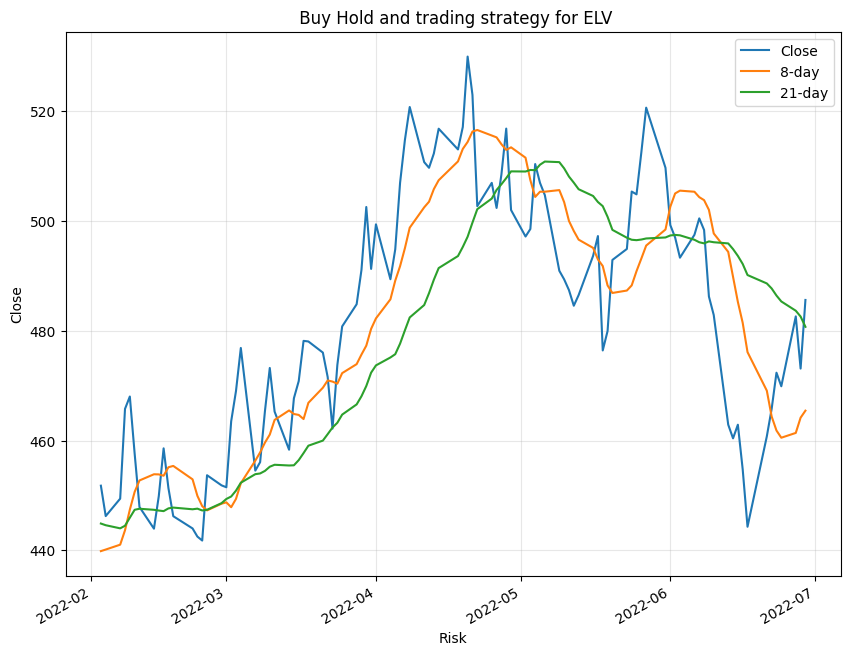

            Day        Open        High         Low       Close       8-day  \
2022-01-03   22  461.799988  465.029999  456.130005  464.859985  459.774998   
2022-01-04   23  465.769989  467.000000  457.570007  458.170013  462.071247   
2022-01-05   24  460.940002  465.130005  458.049988  458.220001  462.603748   
2022-01-06   25  445.829987  452.929993  432.970001  439.450012  462.917500   
2022-01-07   26  435.829987  438.420013  426.279999  434.989990  460.408752   

                21-day  logClose    return  
2022-01-03  437.829046  6.141736  0.000000  
2022-01-04  440.929998  6.127240 -0.014496  
2022-01-05  443.938094  6.127349  0.000109  
2022-01-06  446.538095  6.085524 -0.041825  
2022-01-07  447.881429  6.075323 -0.010201  
            Day        Open        High         Low       Close       8-day  \
2022-01-03   22  565.030029  567.469971  555.510010  566.710022  559.119995   
2022-01-04   23  564.229980  568.719971  561.789978  564.229980  561.779999   
2022-01-05   24  5

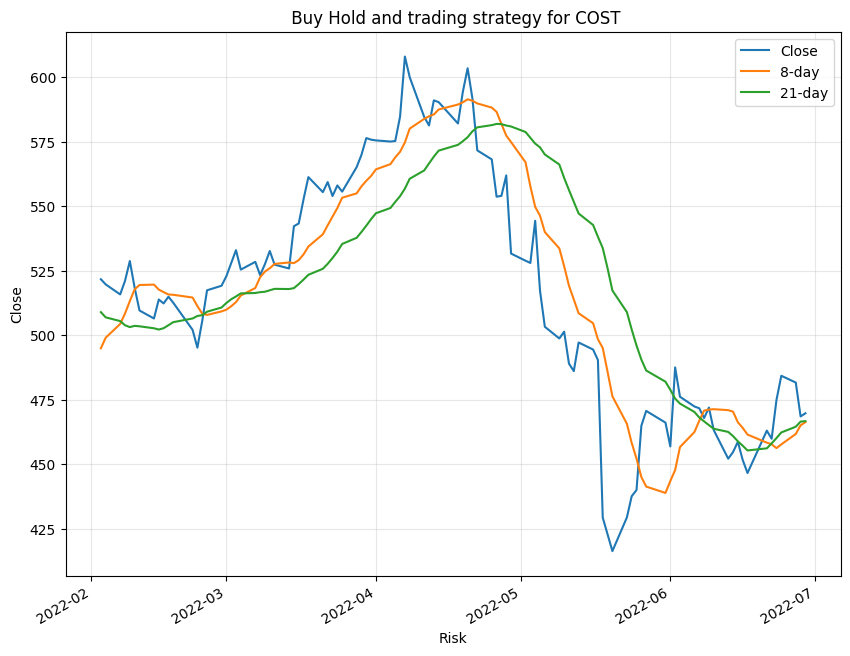

            Day        Open        High         Low       Close       8-day  \
2022-01-03   22  565.030029  567.469971  555.510010  566.710022  559.119995   
2022-01-04   23  564.229980  568.719971  561.789978  564.229980  561.779999   
2022-01-05   24  563.690002  565.049988  549.770020  549.919983  563.599998   
2022-01-06   25  546.200012  553.520020  543.549988  549.799988  563.543747   
2022-01-07   26  547.549988  548.369995  534.239990  536.179993  561.834999   

                21-day  logClose    return  
2022-01-03  549.177141  6.339848  0.000000  
2022-01-04  551.139047  6.335462 -0.004386  
2022-01-05  552.819999  6.309773 -0.025689  
2022-01-06  553.616188  6.309555 -0.000218  
2022-01-07  553.986662  6.284470 -0.025085  
            Day       Open       High        Low      Close      8-day  \
2022-01-03   22  72.029999  73.959999  72.019997  73.769997  72.082500   
2022-01-04   23  74.559998  77.379997  74.279999  76.970001  72.468750   
2022-01-05   24  77.980003  78.26

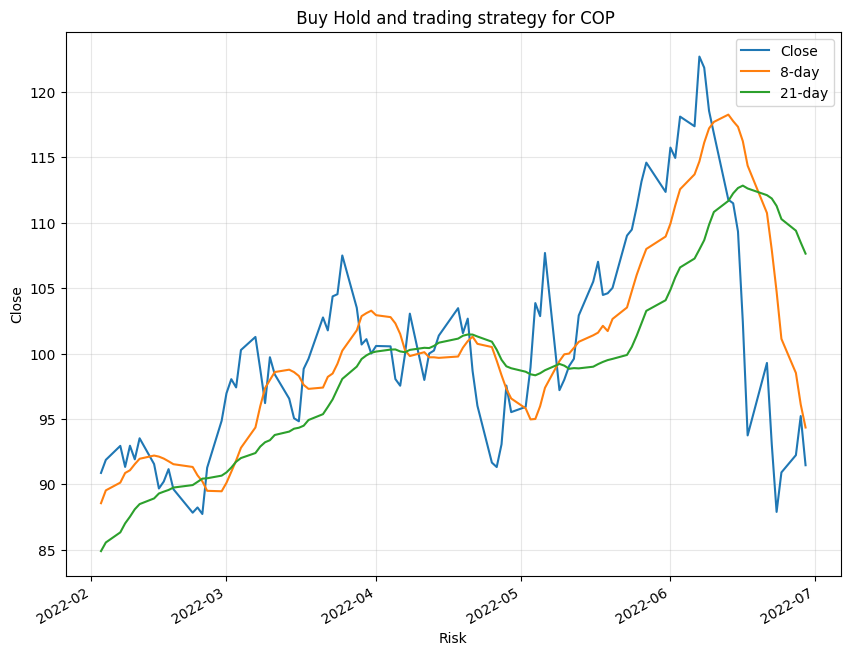

            Day       Open       High        Low      Close     8-day  \
2022-01-03   22  72.029999  73.959999  72.019997  73.769997  72.08250   
2022-01-04   23  74.559998  77.379997  74.279999  76.970001  72.46875   
2022-01-05   24  77.980003  78.269997  75.519997  75.650002  73.20500   
2022-01-06   25  77.820000  78.790001  76.900002  78.489998  73.76250   
2022-01-07   26  78.870003  80.930000  78.379997  80.639999  74.42250   

               21-day  logClose    return  
2022-01-03  71.803809  4.300952  0.000000  
2022-01-04  71.923333  4.343416  0.042464  
2022-01-05  72.202381  4.326117 -0.017298  
2022-01-06  72.337619  4.362971  0.036854  
2022-01-07  72.524285  4.389995  0.027024  


In [ ]:
ticker = ["ELV", "COST", "COP"]
start_date ='12/02/2021'
end_date='12/02/2022'
returnMPTDf= pd.DataFrame(columns=['TICKER','RETURN','ALLOCATION'])
mergedBH=pd.DataFrame(columns=['index', 'Day', 'Open', 'High', 'Low', 'Close', '8-day', '21-day',
       'logClose', 'return', 'invested', 'signal', 'system_return', 'value','month'])


for x in range(0,len(ticker)):
  gld = si.get_data(ticker[x],start_date = start_date,end_date= end_date,interval='1d')
  day = np.arange(1, len(gld) + 1) #generate list of trading days
  gld['Day'] = day
  # Dropping columns I don't want to use
  gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
  # Reorganizing the columns
  gld = gld[['Day', 'open', 'high', 'low', 'close']]
  # Renaming the columns
  gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
  #gld.head()


  gld['8-day'] = gld['Close'].rolling(8).mean().shift()
  gld['21-day'] = gld['Close'].rolling(21).mean().shift()
  gld.dropna(inplace=True)
  #gld.head(n=10)
  print(gld.head(n=10))
  gld.iloc[22:123,[4,5,6]].plot(figsize=(10,8))
  plt.grid(True, alpha = .3)
  title(' Buy Hold and trading strategy for ' + ticker[x])
  xlabel('Risk')
  ylabel('Close')
  plt.show()

  #BUY AND HOLD
  gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
  gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
  gld.fillna(0, inplace=True)
  print(gld.head())
  gld=gld.reset_index()
  gld=gld.rename(columns={'index':'month'})
  mergedBH=pd.merge(gld,mergedBH,on='month',how='left',suffixes=('_'+ticker[x],''))

  #sum = np.exp(np.sum(gld['return'])) -1
  #print("Return of Buy and Hold =", sum) #Return of Buy and Hold
  returnMPTDf.loc[len(returnMPTDf)] = [ticker[x],np.exp(np.sum(gld['return'])) -1,allocationDf[ticker].values[0][x]]

In [ ]:
mergedBH['month']=mergedBH['month'].to_numpy().astype('datetime64[M]')

In [ ]:
mergedBH['value']=mergedBH['return']*(100000)+100000
ticker = ["ELV", "COST", "COP"]
for ticker in ticker:
  mergedBH['value_'+ ticker]=mergedBH['return_'+ ticker]*(100000*allocationDf[ticker].values[0])+(100000*allocationDf[ticker].values[0])
BHMonthly=mergedBH.drop_duplicates(['month'])
BHMonthly['total_returns_BH'] = mergedBH[['value_ELV', 'value_COST', 'value_COP']].sum(axis=1)
BHMonthly[['month', 'return_ELV', 'return_COST', 'return_COP', 'value_ELV', 'value_COST', 'value_COP', 'total_returns_BH']]

<ipython-input-44-7bf7cdc74cc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BHMonthly['total_returns_BH'] = mergedBH[['value_ELV', 'value_COST', 'value_COP']].sum(axis=1)


,month,return_ELV,return_COST,return_COP,value_ELV,value_COST,value_COP,total_returns_BH
0,2022-01-01,0.000000,0.000000,0.000000,67748.626563,32248.567530,0.553018,99997.747112
20,2022-02-01,-0.004751,0.006472,0.032418,67426.780309,32457.292653,0.570946,99884.643909
39,2022-03-01,-0.000775,0.007062,0.021896,67696.127679,32476.311272,0.565128,100173.004078
62,2022-04-01,0.016375,-0.000486,0.005783,68858.015596,32232.885024,0.556217,101091.456837
82,2022-05-01,-0.009649,-0.005223,0.004179,67094.896148,32080.131734,0.555329,99175.583211
103,2022-06-01,-0.020659,-0.019996,0.029725,66349.013862,31603.720630,0.569457,97953.303949
124,2022-07-01,0.007021,0.013430,0.012943,68224.276871,32681.656751,0.560176,100906.493799
144,2022-08-01,-0.013080,0.010128,-0.024205,66862.448714,32575.173192,0.539632,99438.161538
167,2022-09-01,0.010377,0.013451,-0.017698,68451.630888,32682.330607,0.543231,101134.504727
188,2022-10-01,0.034235,0.011495,0.071907,70067.978417,32619.261901,0.592784,102687.833103


## 3.2 - Momentum trading strategy for each stock in the MPT portfolio

<ipython-input-45-1e79f5497152>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gld['8-day'] = gld['Close'].rolling(8).mean().shift()
<ipython-input-45-1e79f5497152>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gld['21-day'] = gld['Close'].rolling(21).mean().shift()
<ipython-input-45-1e79f5497152>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

ticker:ELV:-0.0979309091385292
       index  Day        Open        High         Low       Close       8-day  \
0 2022-01-03   22  461.799988  465.029999  456.130005  464.859985  459.774998   
1 2022-01-04   23  465.769989  467.000000  457.570007  458.170013  462.071247   
2 2022-01-05   24  460.940002  465.130005  458.049988  458.220001  462.603748   
3 2022-01-06   25  445.829987  452.929993  432.970001  439.450012  462.917500   
4 2022-01-07   26  435.829987  438.420013  426.279999  434.989990  460.408752   

       21-day  logClose    return  invested  signal  system_return  
0  437.829046  6.141736  0.000000         1     0.0       0.000000  
1  440.929998  6.127240 -0.014496         1     0.0      -0.014496  
2  443.938094  6.127349  0.000109         1     0.0       0.000109  
3  446.538095  6.085524 -0.041825         1     0.0      -0.041825  
4  447.881429  6.075323 -0.010201         1     0.0      -0.010201  
ticker:COST:0.04503630296432792
       index  Day        Open       

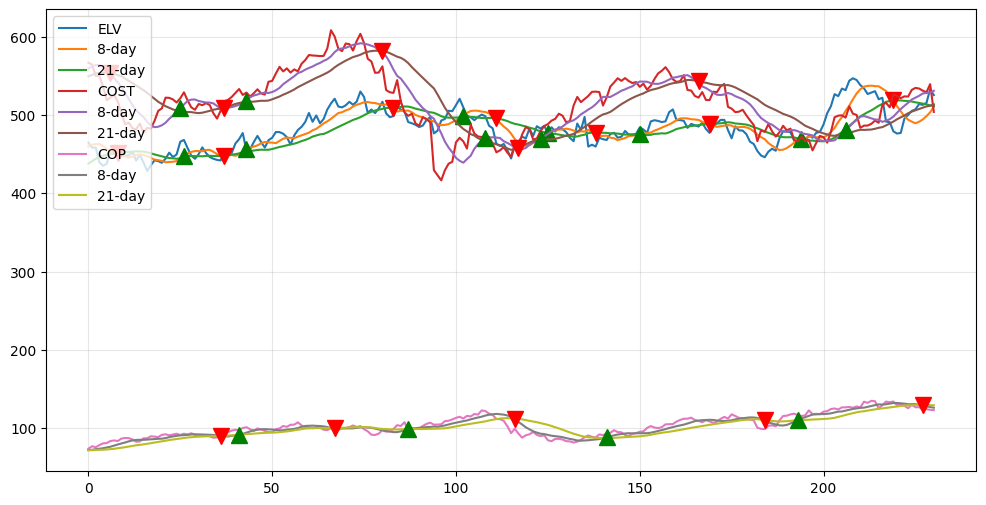

In [ ]:
ticker = ["ELV", "COST", "COP"]
start_date ='12/02/2021'
end_date='12/02/2022'
mergedDf=pd.DataFrame(columns=['index','signal','invested','Day', 'Open', 'High', 'Low', 'Close', '8-day', '21-day', 'logClose','return'])
mergedMT=pd.DataFrame(columns=['index', 'Day', 'Open', 'High', 'Low', 'Close', '8-day', '21-day',
       'logClose', 'return', 'invested', 'signal', 'system_return', 'value','month'])
for x in range(0,len(ticker)):
  gld = si.get_data(ticker[x],start_date = start_date,end_date= end_date,interval='1d')
  day = np.arange(1, len(gld) + 1) #generate list of trading days
  gld['Day'] = day
  # Dropping columns I don't want to use
  gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
  # Reorganizing the columns
  gld = gld[['Day', 'open', 'high', 'low', 'close']]
  # Renaming the columns
  gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
  #gld.head()


  gld['8-day'] = gld['Close'].rolling(8).mean().shift()
  gld['21-day'] = gld['Close'].rolling(21).mean().shift()
  gld.dropna(inplace=True)
  #gld.head(n=10)

  gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
  gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
  gld.fillna(0, inplace=True)
  #gld.head()


  # the np.where() function is similar to the Excel =IF() statement
  gld['invested'] = np.where(gld['8-day'] > gld['21-day'], 1, 0)
  #gld.head()
  #print(gld['invested'].value_counts())

  # the variable signal tells you when you buy and sell
  # we will use it to make red and green triangles
  gld['signal'] = gld['invested'].diff()
  #print(gld['signal'].value_counts())
  gld.fillna(0, inplace=True)
  gld[gld['signal'].isin([1,-1])]
  gld=gld.reset_index()
  mergedDf=pd.merge(mergedDf,gld,on=['index'],how='right',suffixes =('','_'+ticker[x]))



  # The 'system_return' tells you how much money you would have made
  # using your momentum trading algorithm!
  gld['system_return'] = gld['invested'] * gld['return']
  print('ticker:'+ticker[x]+':'+str(np.exp(np.sum(gld['system_return'])) -1))
  print(gld.head())
  gld=gld.rename(columns={'index':'month'})
  mergedMT=pd.merge(gld,mergedMT,on='month',how='left',suffixes=('_'+ticker[x],''))
    # show the last year
  plt.rcParams['figure.figsize'] = 12, 6
  plt.grid(True, alpha = .3)
  plt.plot(gld.iloc[-252:]['Close'], label = ticker[x]) # actual value
  plt.plot(gld.iloc[-252:]['8-day'], label = '8-day') # 8-day average
  plt.plot(gld.iloc[-252:]['21-day'], label = '21-day') # 21-day average
  plt.plot(gld[-252:].loc[gld.signal == 1].index, gld[-252:]['8-day'][gld.signal == 1], '^',
          color = 'g', markersize = 12)
  plt.plot(gld[-252:].loc[gld.signal == -1].index, gld[-252:]['21-day'][gld.signal == -1], 'v',
          color = 'r', markersize = 12)
  plt.legend(loc=2);



In [ ]:
mergedMT.columns

Index(['month', 'Day_COP', 'Open_COP', 'High_COP', 'Low_COP', 'Close_COP',
       '8-day_COP', '21-day_COP', 'logClose_COP', 'return_COP', 'invested_COP',
       'signal_COP', 'system_return_COP', 'Day_COST', 'Open_COST', 'High_COST',
       'Low_COST', 'Close_COST', '8-day_COST', '21-day_COST', 'logClose_COST',
       'return_COST', 'invested_COST', 'signal_COST', 'system_return_COST',
       'Day_ELV', 'Open_ELV', 'High_ELV', 'Low_ELV', 'Close_ELV', '8-day_ELV',
       '21-day_ELV', 'logClose_ELV', 'return_ELV', 'invested_ELV',
       'signal_ELV', 'system_return_ELV', 'index', 'Day', 'Open', 'High',
       'Low', 'Close', '8-day', '21-day', 'logClose', 'return', 'invested',
       'signal', 'system_return', 'value'],
      dtype='object')

In [ ]:
mergedMT['month']=mergedBH['month'].to_numpy().astype('datetime64[M]')

In [ ]:
mergedMT['value']=mergedMT['return']*(100000)+100000
ticker = ["ELV", "COST", "COP"]
for ticker in ticker:
  mergedMT['value_'+ ticker]=mergedMT['system_return_'+ ticker]*(100000*allocationDf[ticker].values[0])+(100000*allocationDf[ticker].values[0])
MTMonthly=mergedMT.drop_duplicates(['month'])
MTMonthly['total_returns_MT'] = mergedMT[['value_ELV', 'value_COST', 'value_COP']].sum(axis=1)
MTMonthly[['month', 'return_ELV', 'return_COST', 'return_COP', 'value_ELV', 'value_COST', 'value_COP', 'total_returns_MT']]

<ipython-input-48-3603ee3a2bbe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MTMonthly['total_returns_MT'] = mergedMT[['value_ELV', 'value_COST', 'value_COP']].sum(axis=1)


,month,return_ELV,return_COST,return_COP,value_ELV,value_COST,value_COP,total_returns_MT
0,2022-01-01,0.000000,0.000000,0.000000,67748.626563,32248.567530,0.553018,99997.747112
20,2022-02-01,-0.004751,0.006472,0.032418,67748.626563,32248.567530,0.570946,99997.765040
39,2022-03-01,-0.000775,0.007062,0.021896,67748.626563,32248.567530,0.553018,99997.747112
62,2022-04-01,0.016375,-0.000486,0.005783,68858.015596,32232.885024,0.556217,101091.456837
82,2022-05-01,-0.009649,-0.005223,0.004179,67094.896148,32248.567530,0.553018,99344.016697
103,2022-06-01,-0.020659,-0.019996,0.029725,66349.013862,32248.567530,0.569457,98598.150849
124,2022-07-01,0.007021,0.013430,0.012943,67748.626563,32681.656751,0.553018,100430.836333
144,2022-08-01,-0.013080,0.010128,-0.024205,67748.626563,32575.173192,0.539632,100324.339388
167,2022-09-01,0.010377,0.013451,-0.017698,68451.630888,32248.567530,0.543231,100700.741650
188,2022-10-01,0.034235,0.011495,0.071907,67748.626563,32248.567530,0.553018,99997.747112


## 3.3 - Momentum trading strategy for the entire MPT portfolio

In [ ]:
ticker = ["ELV", "COST", "COP"]
#mergedDf[['signal_ELV','Close','Close_ELV','Close_COST','Close_COP','invested_ELV']].head()
mergedDf['total_return']=mergedDf['return_ELV']+mergedDf['return_COST']+mergedDf['return_COP']
total=-100
for x in ticker:
  mergedDf['system_return'] = mergedDf['return_'+x] * mergedDf['total_return']
  print('ticker:'+x+'='+str(np.exp(np.sum(mergedDf['system_return'])) -1))
  if  np.exp(np.sum(mergedDf['system_return'])) -1 > total:
    total=np.exp(np.sum(mergedDf['system_return'])) -1

ticker:ELV=0.1407656459796145
ticker:COST=0.1691859972527412
ticker:COP=0.24938311765099197


In [ ]:
total
total*100000+100000

124938.31176509919

In [ ]:
mergedDf['month']=mergedDf['index'].to_numpy().astype('datetime64[M]')

In [ ]:
mergedDf=mergedDf[['month','return_ELV','return_COST','return_COP','total_return']]
for x in ticker:
  mergedDf['value_'+x]=(mergedDf['return_'+x]*(100000*allocationDf[x].values[0]))+(100000*allocationDf[x].values[0])
  mergedDf['allocation_'+x]=allocationDf[x].values[0]
mergedDf['total_value']=(mergedDf['total_return']*100000)+100000
MTPMonthly=mergedDf.drop_duplicates(['month'])[['month', 'return_ELV', 'return_COST', 'return_COP', 'total_return','value_ELV', 'value_COST','value_COP', 'total_value']]
MTPMonthly

<ipython-input-52-bfc5d5f150e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedDf['value_'+x]=(mergedDf['return_'+x]*(100000*allocationDf[x].values[0]))+(100000*allocationDf[x].values[0])
<ipython-input-52-bfc5d5f150e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedDf['allocation_'+x]=allocationDf[x].values[0]
<ipython-input-52-bfc5d5f150e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,month,return_ELV,return_COST,return_COP,total_return,value_ELV,value_COST,value_COP,total_value
0,2022-01-01,0.000000,0.000000,0.000000,0.000000,67748.626563,32248.567530,0.553018,100000.000000
20,2022-02-01,-0.004751,0.006472,0.032418,0.034140,67426.780309,32457.292653,0.570946,103414.023826
39,2022-03-01,-0.000775,0.007062,0.021896,0.028184,67696.127679,32476.311272,0.565128,102818.361413
62,2022-04-01,0.016375,-0.000486,0.005783,0.021672,68858.015596,32232.885024,0.556217,102167.203992
82,2022-05-01,-0.009649,-0.005223,0.004179,-0.010694,67094.896148,32080.131734,0.555329,98930.647670
103,2022-06-01,-0.020659,-0.019996,0.029725,-0.010930,66349.013862,31603.720630,0.569457,98906.963554
124,2022-07-01,0.007021,0.013430,0.012943,0.033394,68224.276871,32681.656751,0.560176,103339.396926
144,2022-08-01,-0.013080,0.010128,-0.024205,-0.027158,66862.448714,32575.173192,0.539632,97284.215510
167,2022-09-01,0.010377,0.013451,-0.017698,0.006129,68451.630888,32682.330607,0.543231,100612.934426
188,2022-10-01,0.034235,0.011495,0.071907,0.117637,70067.978417,32619.261901,0.592784,111763.662421


## 3.4 - Buy-and-Hold strategy for the S&P 500 index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-12-02 to 2022-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     252 non-null    int64  
 1   Open    252 non-null    float64
 2   High    252 non-null    float64
 3   Low     252 non-null    float64
 4   Close   252 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


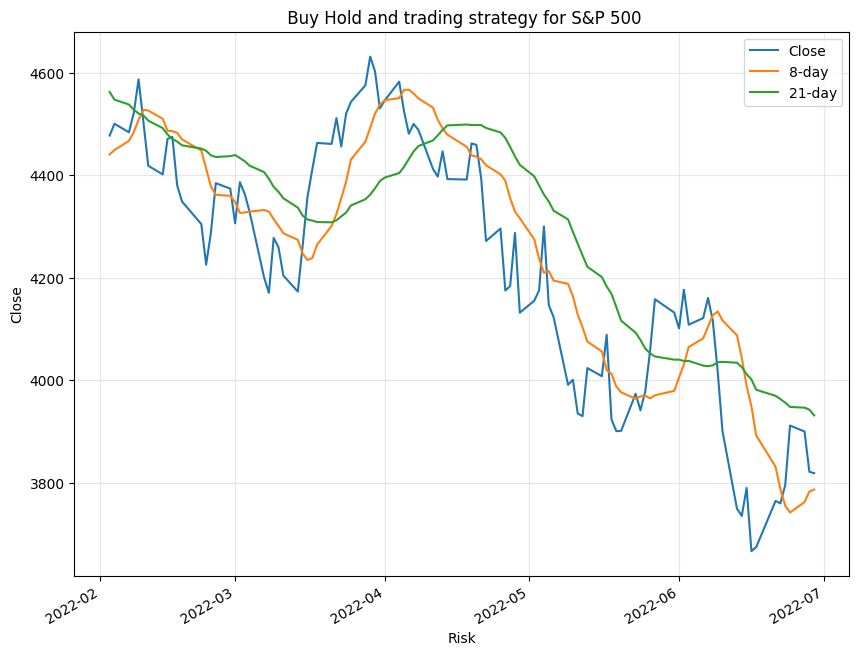

-0.1501054883998384

In [ ]:
ticker = "^GSPC"
gld = si.get_data(ticker,start_date = '12/02/2021',end_date='12/02/2022',interval='1d')
day = np.arange(1, len(gld) + 1) #generate list of trading days
gld['Day'] = day
# Dropping columns I don't want to use
gld.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
gld = gld[['Day', 'open', 'high', 'low', 'close']]
# Renaming the columns
gld.columns = ['Day', 'Open', 'High', 'Low', 'Close']
gld.head()
gld.info()
# rolled back (no data leakage)
# since this cell is run after, this overwrites the previous data leakage
# you can comment out the cell above and run all if you are nervous!
gld['8-day'] = gld['Close'].rolling(8).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld.dropna(inplace=True)
gld.head(n=10)
# imagine where you would put markers on the plot
# for buy vs. sell...

# the 22:123 shows the first 100 days of trading
gld.iloc[22:123,[4,5,6]].plot(figsize=(10,8))
plt.grid(True, alpha = .3)
title(' Buy Hold and trading strategy for S&P 500')
xlabel('Risk')
ylabel('Close')
plt.show()

gld['logClose'] = np.log(gld['Close']) # price will always be positive, so this operation is well-defined
gld['return'] = gld['logClose'].diff() # the difference will be positive or negative
gld.head()

gld.fillna(0, inplace=True)
gld.head()
np.exp(np.sum(gld['return'])) -1
# buy and hold finish

In [ ]:
gld=gld.reset_index()
gld['month']=gld['index'].to_numpy().astype('datetime64[M]')

In [ ]:
test=gld[['month','return']]
test['value_SP']=test['return']*(100000)+100000
SPMonthly=test.drop_duplicates(['month'])
SPMonthly

<ipython-input-55-3ec4e7253dcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value_SP']=test['return']*(100000)+100000


,month,return,value_SP
0,2022-01-01,0.000000,100000.000000
20,2022-02-01,0.006840,100683.956035
39,2022-03-01,-0.015594,98440.553221
62,2022-04-01,0.003404,100340.442096
82,2022-05-01,0.005659,100565.919929
103,2022-06-01,-0.007511,99248.909496
124,2022-07-01,0.010499,101049.851130
144,2022-08-01,-0.002827,99717.292346
167,2022-09-01,0.002992,100299.175227
188,2022-10-01,0.025555,102555.457753


## 3.5 - Plot Comparing the Investment Strategies

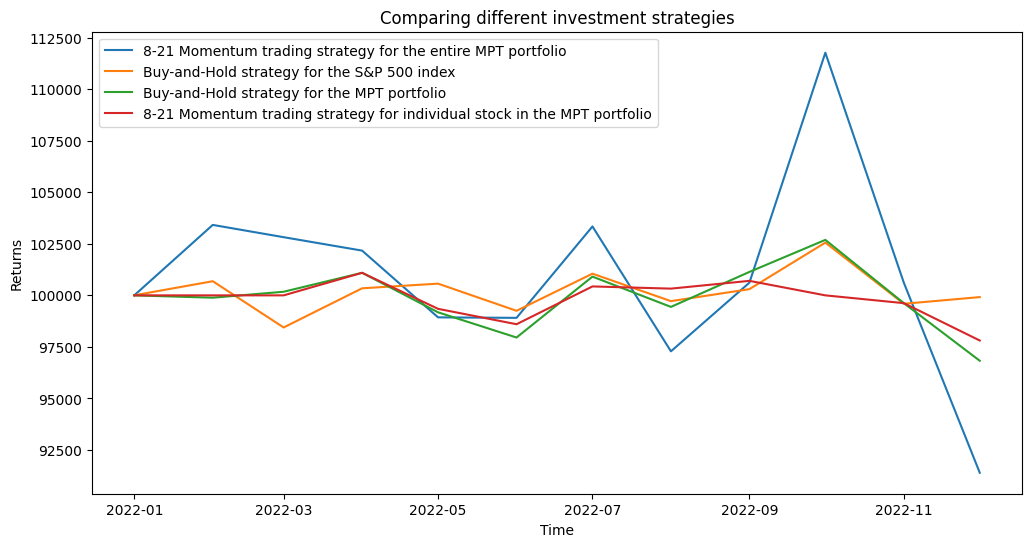

In [ ]:
plotDf=pd.merge(MTPMonthly,SPMonthly,on='month',how='inner',suffixes=('_MTP','_SP'))
plotDf=pd.merge(plotDf,BHMonthly,on='month',how='inner',suffixes=('','_BH'))
plotDf=pd.merge(plotDf,MTMonthly,on='month',how='inner',suffixes=('','_MT'))
#plotDf[['month','return','return_BH','return_MT','total_return']]


#plotDf[['month','total_value','value','value_BH','total_value_MT']]
plt.plot(plotDf['month'],plotDf['total_value'], label='8-21 Momentum trading strategy for the entire MPT portfolio')
plt.plot(plotDf['month'],plotDf['value_SP'], label='Buy-and-Hold strategy for the S&P 500 index')
plt.plot(plotDf['month'],plotDf['total_returns_BH'], label='Buy-and-Hold strategy for the MPT portfolio')
plt.plot(plotDf['month'],plotDf['total_returns_MT'], label='8-21 Momentum trading strategy for individual stock in the MPT portfolio')
title('Comparing different investment strategies')
xlabel('Time')
ylabel('Returns')
plt.legend(loc=2)

## 3.6 - Discussion and Comparison of the Investment Strategies

1) Based on the above plot, 8-21 momentum trading strategy applied together for the entire MPT portfolio had the highest volatility with very high ups and downs. This is the strategy with highest risk due to it's high volatility.

2) 8-21 momemtum trading strategy applied separately for each individual stock in the MPT portfolio had the lowest volatility with lower ups and downs. This is the strategy with lowest risk due to it's low volatility.

3) Though all the four strategies had convegent behaviour during few months, these strategies mostly had divergent behaviour.

3) Choosing high risk strategies can lead to higher profits but they also can lead to higher losses as well. Using a combination of strategies based on the risk taking capacity will be an ideal approach.

4) Returns have been very low for the other three strategies excluding 8-21 momentum trading strategy for the entire MPT portfolio.

# 4 - Conclusion

## 4.1 - Thoughts and Insights

1) Portfolio optimization is essesntial for investors to optimize their stock allocation for maximizing profits at a given risk level.

2) As the risk increases, the reward increases at a rapid pace initially but slowly becomes stagnant with further increase in the risk.

3) At low levels of risk, the portfolio is very diverse with investments made in stocks which are spread across various sectors. As the risk increases, number of stocks in the portfolio decrease slowly and will only have one stock having 100 % allocation after a certain stage.

4) Choosing highly volatile stocks for investment can lead to higher risk. Though investing in such stocks can lead to higher profits, they can lead to higher losses as well.

5) Stocks in a particular sector may exhibit convergent trends like we observed in the stocks of the energy sector. Due to this reason, investing in only one sector can lead to higher risk.

6) Based on the stocks we chose for the analysis, 8-21 momentum trading strategy for the entire MPT portfolio had a good probability of obtaining higher profits but it can also lead to higher losses.

7) Returns from most of the strategies are very low but the risk of higher losses is also very less.